# Inverting the Formula for the Ising Coupling Matrix 

## Notes on Network Performance

Currently the parameters $\mu$ and $\Omega$ are taken from a uniform distribution. The output activations will also lie in the (0,1) interval. The expected distance between two values drawn from a uniform [0,1] distribution is $\frac{1}{3}$. Since we have $n^2+n$ parameters for an ion chain of size n, we get that if the network is outputting just a guess that the cost should be approximately $\frac{n^2+n}{6}$.(since we are currently using a quadratic cost function)

For a network with n=3 I have been able to get a cost of just under a quarter of this value for my synthetic data set up to this point.
I am still researching ways to improve hyperparameter selection as well as improved network architecture.

One question I have is to evaluate what is a good cost value for the test set and what is not. And whether or not it is a good physical representation of the system to have the parameters taken from a uniform distribution.

In [50]:
import ionchain
import classes
import pickle
import numpy as np
import network
import network2
import matplotlib.pyplot as plt
import sklearn.preprocessing
% matplotlib inline

## Functions to Model the Physical System
These functions, Lambe_Dicke J_ij1 and J_ij used to make the necessary calculations to model an instance of an ion chain.

In [51]:
def Lamb_Dicke(ic):
    """Computes Lamb-Dicke parameters for a trapped ion chain 
    
    Args:
        ic (Object) - an instance of a trapped ion chain
        
    Returns:
        An nxn matrix where n is the number of ions in the ion chain.
        The i,mth entry of the matrix corresponds to the Lambe-Dicke
        parameter eta[i,m] which sets the scale for the coupling between
        spin i and mode m.
    """
    deltak = 2*1.7699*10**7
    M = 2.8395 * 10**(-25)
    hbar = 1.0546e-34
    n = ic.n
    b_ij = ic.x_eigvecs
    omega_m = ic.x_freqs
    eta = np.empty([n,n])
    for m in range(n):
        for i in range(n):
            eta[i,m] = b_ij[i,m]*deltak*((hbar/(2*M*omega_m[m]))**0.5)
    return eta

In [52]:
def J_ij1(mu, Rabi_freq, ic):
    """Computes spin-spin coupling beteen atoms in a trapped ion
    chain with global beatnote detuning. 
    
    Args:
        mu(float) - global beatnote detuning parameter
        ic (Object) - an instance of a trapped ion chain
        Rabi_freq(An 1Xn vector of floats, where n is number of ions
        in the chain) 
            - containing where the ith entry is the single spin Rabi
            frequency of atom i
        
    Returns:
        An nxn matrix where n is the number of ions in the ion chain.
        The i,jth is the spin-spin coupling beteen atoms i and j in the
        ion chain.
    """
    n = ic.n
    eta = Lamb_Dicke(ic)
    omega_m = ic.x_freqs
    J = np.empty((n,n))
    for i in range(n):
        J[i,i] = 0
        for j in range(i+1,n):
            J[i,j] = Rabi_freq[i]*Rabi_freq[j]* np.sum(eta[i, :] * eta[j, :] * omega_m[:] /(np.full((1,n),mu)**2 - omega_m[:]**2))
    return J

In [53]:
def J_ij(mus, Rabi_freq_matrix, ic):
    n = ic.n
    eta = Lamb_Dicke(ic)
    omega_m = ic.x_freqs
    F = np.empty((n, n, len(mus)))
    for i in range(n):
        for j in range(n):
            for m in range(len(mus)):
                F[i, j, m] = np.sum(eta[i, :] * eta[j, :] * omega_m[:] /
                                    (mus[m]**2 - omega_m[:]**2))
    J = np.empty((n, n))
    for i in range(n):
        J[i, i] = 0
        for j in range(i + 1, n):
            J[i, j] = np.sum(Rabi_freq_matrix[i, :] * Rabi_freq_matrix[j, :] * F[i, j, :])
            J[j, i] = J[i, j]

    return J

## Generating Synthetic Data
The functions data_creator and create_data_file are used to generate synthetic data for training, testing, and validation.

To create a synthetic data set one must just modify the code in the cell below the one where these functions are defined.

In [54]:
def data_creator(ic, data_size, triangular=False):
    """Generates training, test and validation data for a 
    particular ion chain ic. The function returns 3 tuples corresponding 
    to each data set. Each tuple contains 2 items. The first is the J_ij
    values for the system in vectorized form(by row). If n is the size of
    the ion chain, the second contains a vector whose first n entires
    are the parameters mu and the remaining entires are the vectorized
    form of the Rabi frequency matrix
    
    Arguments:
    ic(Object from IonChain Class)-the ion chain from which to construct
    data from
    data_size(Int)-desired data size"""
    n = ic.n
    np.random.seed(123)
    
    # Generate random values for the Rabi matricies and detunings(the first mu_size values correspond
    #to mu and the rest to the Rabi frequencies.
    # The size of the ion chain will determine the number of output values in the network.
    data = []
    for i in range (0, data_size):
        mu = np.random.uniform(low=0, high=1, size=(n,1))
        Rabi = np.random.uniform(low=0, high=1, size=(n,n))     
    # For each set of parameters y we generate corresponding Ising coupling matrix J which
    # will be our input parameters for the neural network
        J = J_ij(mu, Rabi, ic)
        if triangular:
            J = J[np.triu_indices(n,1)]
            x = np.reshape(J, ((n*(n+1))/2-n,1))
        else:
            x = np.reshape(J,(n**2,1))
        y = np.concatenate((mu, np.reshape(Rabi,(n**2,1))), axis=0)
        data.append((x,y))  
    
    # Return the dataset in pairs of x,y for train/test/validation sets.
    return data

def mean_variance(i, j, ic, data_set):
    """Given an ionchain and a data set returns a tuple containing the
    mean and variance of the i,jth entries in the of the J_ijs in the
    data set"""
    n = ic.n
    Jijs = [np.reshape(pair[0],(n,n))[i,j] for pair in data_set]
    mean = sum(Jijs)/len(Jijs)
    variance = [(Jij - mean)**2 for Jij in Jijs]/len(Jijs)
    return (mean, variance)

def normalize(ic, data_set):
    n = ic.n
    Js = data_set[0][0]
    for i in len(1,data_set):
        Js = np.concatenate((Js,data_set[0][i]))
    standardized_Js = preprocessing.scale(Js)
    standardized_data_set = []
    for i in len(data_set):
        x_val = np.reshape(standardized_Js[:,i],(n,1))
        y_val = data_set[i][1]
        standardized_data_set += (x_val,y_val)
    return standardized_data_set
    

def create_data_file(filename, ic, data_size, normalize=False):
    """Creates a pickled file containing synthetic test data.
    Arguments:
    filename(string)-desired filename
    ic(Object from IonChain Class)-the ion chain from which to construct
    data from
    data_size(Int)-desired data size"""
    n = ic.n
    data = data_creator(ic, data_size)
    d = {}
    if normalize:
        Js = [Jij[0] for Jij in data]
        all_Js = np.hstack(Js)
        means = np.reshape(np.mean(all_Js, axis=1),(n,n))
        std_dev = np.reshape(np.std(all_Js, axis=1),(n,n))
        d['means'] = means
        d['std_dev'] = std_dev
        scaled_Jijs = np.split(sklearn.preprocessing.scale(all_Js,axis=1),
                               data_size, axis=1)
        for i in range(len(data)):
            data[i] = (scaled_Jijs[i], data[i][1])
    training_set = data[:int(len(data)*0.6)]
    validation_set = data[int(len(data)*0.6) :int(len(data)*0.8)]
    test_set = data[int(len(data)*0.8):]
    d['train'] = training_set
    d['validation'] = validation_set
    d['test'] = test_set
    d['ionchain'] = ic
    f = open(filename, 'wb')
    pickle.dump(d, f)
    f.close()
    

In [55]:
ionchain3 = ionchain.IonChain(3,[5,1])
create_data_file('chain_len3_normalized.pickle',ionchain3,
                 10000, normalize=True)

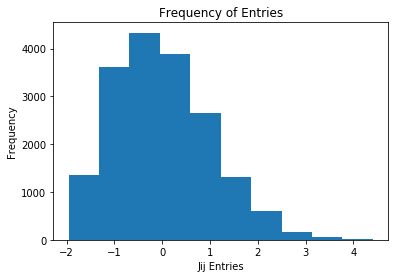

In [56]:
def J_visualization(filename):
    d = pickle.load(open(filename, "rb"))
    ic = d['ionchain']
    n = ic.n
    training_set = d['train']
    Js = [np.reshape(data_pair[0], (n,n)) for data_pair in training_set]
    J_value_list = []
    for J in Js:
        J_value_list += np.ndarray.tolist(J[np.triu_indices(n,1)])
    plt.hist(J_value_list)
    plt.xlabel('Jij Entries')
    plt.ylabel('Frequency')
    plt.title('Frequency of Entries')
    
J_visualization('chain_len3_normalized.pickle')

## Training and Validation
The following code is used to define a create a neural network and its architecture, using a modified version of Micheal Nielsons network2.py file, then train it. After running this code the output will currently be the cost for the training and test data at the end of each epoch stored in an array. Along with a plot for visualization.


In [57]:
def train(filename,architecture,epochs,mini_batch,eta,lmbda=0,save=False,
         save_name=None,eta_update=0):
    d = pickle.load(open(filename, "rb"))
    ic = d['ionchain']
    training_set = d['train']
    validation_set = d['validation']
    test_set = d['test']
    net = network2.Network(architecture)
    net.SGD(training_set, epochs, mini_batch, eta ,lmbda,
        validation_set,eta_update)
    if save:
        if save_name:
            net.save(save_name)
        else:
            print ('Must specify filename, to argument save_name to save network to.')
    return net.total_cost_no_reg(test_data)   

Epoch 0 training complete
Cost on training data: 0.5023403545617781
Cost on evaluation data: 0.49937076611421843
Epoch 1 training complete
Cost on training data: 0.47869220087165937
Cost on evaluation data: 0.4786182327098831
Epoch 2 training complete
Cost on training data: 0.47004590926224116
Cost on evaluation data: 0.4704891277064718
Epoch 3 training complete
Cost on training data: 0.46291396693124615
Cost on evaluation data: 0.46335379998765036
Epoch 4 training complete
Cost on training data: 0.45686517794506587
Cost on evaluation data: 0.45725341381630874
Epoch 5 training complete
Cost on training data: 0.451675004725549
Cost on evaluation data: 0.45202349844239204
Epoch 6 training complete
Cost on training data: 0.44720121072132263
Cost on evaluation data: 0.44742481552562535
Epoch 7 training complete
Cost on training data: 0.4432957399808387
Cost on evaluation data: 0.4435981854705911
Epoch 8 training complete
Cost on training data: 0.43988722606194136
Cost on evaluation data: 0

Cost on evaluation data: 0.4010101161575115
Epoch 73 training complete
Cost on training data: 0.40052487874804754
Cost on evaluation data: 0.40100881139557765
Epoch 74 training complete
Cost on training data: 0.40047581692653306
Cost on evaluation data: 0.4008822286123026
Epoch 75 training complete
Cost on training data: 0.40041362048069773
Cost on evaluation data: 0.40082460481323445
Epoch 76 training complete
Cost on training data: 0.4003649534307185
Cost on evaluation data: 0.4007729017194755
Epoch 77 training complete
Cost on training data: 0.40032603119021715
Cost on evaluation data: 0.40080694769143305
Epoch 78 training complete
Cost on training data: 0.4002905030660133
Cost on evaluation data: 0.4007595513572006
Epoch 79 training complete
Cost on training data: 0.4002463350063855
Cost on evaluation data: 0.4006340991418113
Epoch 80 training complete
Cost on training data: 0.40019794620721205
Cost on evaluation data: 0.400545688400471
Epoch 81 training complete
Cost on training d

Cost on evaluation data: 0.39970312539072433
Epoch 145 training complete
Cost on training data: 0.39934300296417463
Cost on evaluation data: 0.39972273349622417
Epoch 146 training complete
Cost on training data: 0.3993432111293041
Cost on evaluation data: 0.39974643269792026
Epoch 147 training complete
Cost on training data: 0.3993361939977824
Cost on evaluation data: 0.39966295717480915
Epoch 148 training complete
Cost on training data: 0.399338048770212
Cost on evaluation data: 0.39966525687349946
Epoch 149 training complete
Cost on training data: 0.3993335632114063
Cost on evaluation data: 0.3997015466132804


NameError: name 'total_cost_no_reg' is not defined

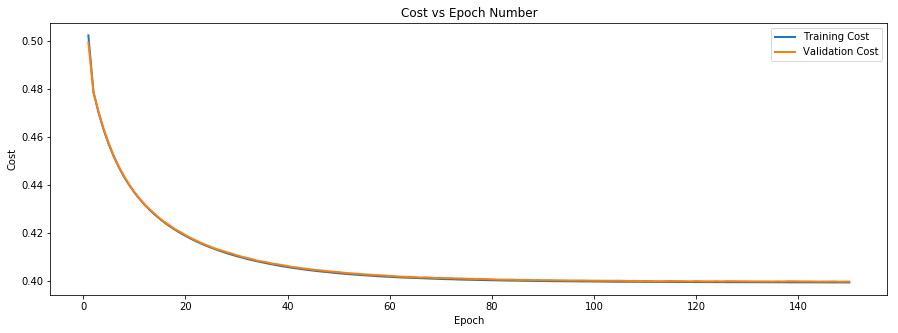

In [58]:
train('chain_len3_normalized.pickle',[9,200,12], 150,10,0.001)

# net = network2.Network([9,1000,12])
# net.SGD(training_data[:1000], 150, 10, 0.001,lmbda = 0.05,
#         evaluation_data=validation_data[:100],eta_update=0)

## Testing
The following code can be modified and used for testing.

In [ ]:
def comparison(J,ic,network):
    """Given an Ising coupling matrix J and a trained neural network """
    n = ic.n
    nn_output = network.feedforward(np.reshape(J,(n**2,1)))
    mu_approx = nn_output[:n]
    Rabi_approx = np.reshape(nn_output[n:],(n,n))
    J_approx = J_ij(mu_approx, Rabi_approx, ic)
    return J_approx

In [ ]:
comparison(np.array([[0,1,0],[1,0,1],[0,1,0]]),ionchain3,net1)